In [1]:
import numpy as np
import torch
import dgl
from torch import nn
from matplotlib import pylab as plt


def get_complete_edges(g):
    def leading_zero(x):
        yield torch.zeros_like(x[0])
        yield from x
    x = torch.cumsum(g.batch_num_nodes(), 0)
    all_edges = []
    for a, b in zip(leading_zero(x), x):
        edges = torch.combinations(torch.arange(a, b))
        all_edges.append(edges)
    return torch.cat(all_edges, 0).T

def add_complete_edges(g):
    n1 = g.number_of_nodes()
    edges = get_complete_edges(g)
    g.add_edges(edges[0], edges[1])
    g.add_edges(edges[1], edges[0])
    n2 = g.number_of_nodes()
    assert n1 == n2
    return g

Using backend: pytorch


# Train on Lung Cancer

## Load Data

In [2]:
import pandas as pd

df = pd.read_csv('lucas0_train.csv')
df.head()

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1


### Loader and Transforms

In [3]:
import typing
from copy import deepcopy


class Compose(typing.Callable):
    
    def __init__(self, *transforms):
        self.transforms = transforms
        
    def __call__(self, x):
        for transform in self.transforms:
            x = transform(x)
        return x
    
class Deepcopy(typing.Callable):
    
    def __call__(self, x):
        return deepcopy(x)

class ToDGLFullyConnected(typing.Callable):
    
    def __init__(self, keys, feature_key='feat', target_key='targ'):
        self.keys = keys
        self.key_to_idx = {k: i for i, k in enumerate(keys)}
        self.feature_key = feature_key
        self.target_key = target_key
        
    @staticmethod
    def leading_zero(x):
        yield torch.zeros_like(x[0])
        yield from x
        
    @classmethod
    def get_complete_edges(cls, g):
        x = torch.cumsum(g.batch_num_nodes(), 0)
        all_edges = []
        for a, b in zip(cls.leading_zero(x), x):
            edges = torch.combinations(torch.arange(a, b))
            all_edges.append(edges)
        return torch.cat(all_edges, 0).T

    @classmethod
    def add_complete_edges(cls, g):
        n1 = g.number_of_nodes()
        edges = cls.get_complete_edges(g)
        g.add_edges(edges[0], edges[1])
        g.add_edges(edges[1], edges[0])
        n2 = g.number_of_nodes()
        assert n1 == n2
        return g
        
    def __call__(self, row):
        g = dgl.graph(([], []))
        g.add_nodes(len(row))
        idx = [self.key_to_idx[k] for k in row.keys()]
        g.ndata[self.feature_key] = torch.tensor(idx).long()
        add_complete_edges(g)
        g.ndata[self.target_key] = torch.tensor(list(row.values())).unsqueeze(1).float()
        return g
    
class CloneNodeData(typing.Callable):
    
    def __init__(self, from_key: str, to_key: str):
        self.from_key = from_key
        self.to_key = to_key
        
    def __call__(self, g):
        g.ndata[self.to_key] = g.ndata[self.from_key].detach().clone()
        return g
        
class MaskNodeData(typing.Callable):
    
    def __init__(self, index: int, key: str, mask_key='m', mask_value=0):
        
        self.index = index
        self.key = key
        self.mask_key = mask_key
        self.mask_value = mask_value
        
        
    def __call__(self, g):
        mask = torch.zeros_like(g.ndata[self.key]).long()
        mask[self.index] = 1
        mask = mask.bool()
        g.ndata[self.mask_key] = mask
        g.ndata[self.key][mask] = self.mask_value
        return g
        
# t = Compose(
#     ToDGLFullyConnected(list(df.columns), feature_key='x', target_key='y'), 
#     CloneNodeData('y', 'y_hat'),
#     MaskNodeData(-1, key='y', mask_key='mask', mask_value=-1))
# t(row.to_dict())


In [4]:
from torch.utils.data import DataLoader, Dataset

class PdDataset(Dataset):
    
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        self.transformed = {}
        
    def __getitem__(self, idx):
        x = self.df.iloc[idx].to_dict()
        if self.transforms:
            if isinstance(self.transforms, (list, tuple)):
                for t in self.transforms:
                    x = t(x)
            elif callable(self.transforms):
                x = self.transforms(x)
            else:
                raise TypeError("Transforms must be callable or an list or tuple of callables")
        return x
    
    def __len__(self):
        return len(self.df)
    
    def split(self, *splits):
        x = torch.tensor(splits)
        x = torch.cumsum(x, 0) / x.sum()
        
        idx = len(self) * x
        idx = [0] + idx.long().tolist()
        idx[-1] = None
        idx[0] = None
        datasets = []
        for i, j in zip(idx[:-1], idx[1:]):
            datasets.append(self.__class__(self.df.iloc[i:j], transforms=self.transforms))
        return datasets 
        
class CachedDataset(Dataset):
    
    def __init__(self, dataset):
        self.cache = {}
        self.dataset = dataset
        
    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]
        else:
            x = self.dataset[idx]
            self.cache[idx] = x
            return x
        
    def __len__(self):
        return len(self.dataset)
    
    def split(self, *splits):
        return [self.__class__(s) for s in self.dataset.split(*splits)]
        
LeaveOneOut = Compose(
    Deepcopy(),
    ToDGLFullyConnected(list(df.columns), feature_key='x', target_key='y'), 
    CloneNodeData('y', 'y_hat'),
    MaskNodeData(-1, key='y', mask_key='mask', mask_value=-1)
)
dataset = PdDataset(df=pd.concat([df, df], ignore_index=True), transforms=LeaveOneOut)

dataset[3000]

Graph(num_nodes=12, num_edges=132,
      ndata_schemes={'x': Scheme(shape=(), dtype=torch.int64), 'y': Scheme(shape=(1,), dtype=torch.float32), 'y_hat': Scheme(shape=(1,), dtype=torch.float32), 'mask': Scheme(shape=(1,), dtype=torch.bool)}
      edata_schemes={})

### Network

In [10]:
from abc import ABC, abstractmethod
from torch import nn
from typing import *
import torch
from copy import deepcopy
import matplotlib as mpl
from matplotlib import cm
from dgl import ops as Fops
from torch.nn import functional as F


def clones(net, N):
    return [deepcopy(net) for _ in range(N)]
    
    
class SizedModule(ABC) :

    @abstractmethod
    def get_size(self) -> int:
        ...
                  
class AddNorm(nn.Module):
    
    def __init__(self, size: Optional[int] = None, dropout: float = 0.1, layer: Optional[SizedModule] = None):
        super().__init__()
        if size is None and layer is None:
            return ValueError("Either size or layer must be provided")
        self.size = size or layer.get_size()
        self.layer = layer
        self.norm = nn.LayerNorm(self.size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, args=None, kwargs=None, layer: Optional[SizedModule] = None):
        kwargs = kwargs or dict()
        if args is None:
            args = (x,)
        layer = layer or self.layer
        return self.norm(x + self.dropout(layer(*args, **kwargs)))
    

    
class MultiHeadAttention(nn.Module):
    
    def __init__(self, dim_model, h):
        super().__init__()
        assert dim_model % h == 0
        self.h = h
        self.dim_model = dim_model
        self.d_k = dim_model // h
        self.linears  = clones(nn.Linear(dim_model, dim_model), 4)
        self.attn = None
    
    def _view_head(self, x):
        return x.view(x.size(0), -1, self.h, self.d_k).transpose(1, 2)
        
    def forward(self, g, query, key, value):
        q = self._view_head(self.linears[0](query))
        k = self._view_head(self.linears[1](key))
        v = self._view_head(self.linears[2](value))
        x = Fops.v_dot_u(g, q, k) / self.d_k**0.5
        score = Fops.edge_softmax(g, x)
#         score = Fops.v_dot_u(g, q, k) / self.d_k**0.5
#         score = F.leaky_relu(Fops.v_dot_u(g, q, k) / self.d_k**0.5)
        out = Fops.u_mul_e_sum(g, v, score)
        out = out.transpose(1, 2).view(g.number_of_nodes(), self.h * self.d_k)
        score = score.view(score.size(0), self.h, -1)
        self.attn = score
        out = self.linears[3](out)
        return out
    

class Network(nn.Module):
    
    def __init__(self, d_model, h=16, n_heads=4, dropout=0.2):
        super().__init__()
        self.src_embedding = nn.Sequential(
            nn.Embedding(d_model, h),
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, h),
            nn.LeakyReLU()
        )
        self.dst_embedding = nn.Sequential(
            nn.Embedding(d_model, h),
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, h),
            nn.LeakyReLU()
        )
        self.encode = nn.Sequential(
            nn.Linear(1, h),
            nn.LeakyReLU(),
        )
        self.attn = AddNorm(h, layer=MultiHeadAttention(h, n_heads), dropout=dropout)
        self.core = nn.Sequential(
            nn.Linear(h, h),
            nn.LeakyReLU(),
        )
        self.decode = nn.Sequential(
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, 1)
        )
            
        
    def forward(self, g, x, y, n_loops=5):
        with g.local_scope():
            g.ndata['a'] = self.src_embedding(x.flatten().long())
            g.ndata['b'] = self.dst_embedding(x.flatten().long())
            g.ndata['h'] = self.encode(y.float())
            out_arr = []
            for i in range(n_loops):

                g.ndata['h'] = self.attn(g.ndata['h'], args=(g, g.ndata['a'], g.ndata['b'], g.ndata['h']))
                g.ndata['h'] = self.core(g.ndata['h'])
                out = nn.Sigmoid()(self.decode(g.ndata['h']))
                out_arr.append(out)
            
            return out_arr
        
net = Network(d_model=len(df.columns)*2, h=128, n_heads=4, dropout=0.2)
g = dataset[0]
net(g, g.ndata['x'], g.ndata['y']);

### Training for Lung Cancer Prediction

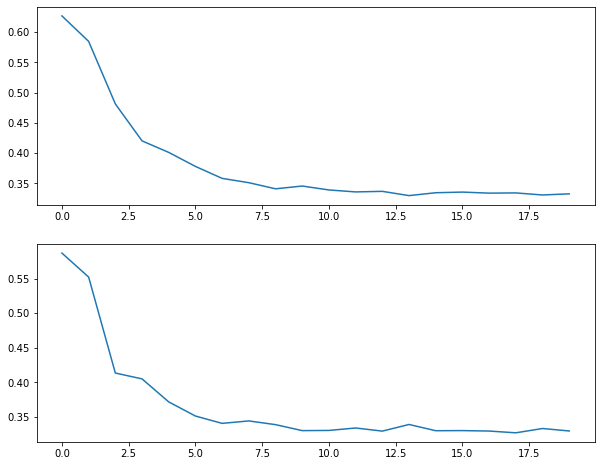

KeyboardInterrupt: 

In [51]:
from tqdm.auto import tqdm
from IPython import display


LeaveOneOut = Compose(
#     Deepcopy(),
    ToDGLFullyConnected(list(df.columns), feature_key='x', target_key='y'), 
    CloneNodeData('y', 'y_hat'),
    MaskNodeData(-1, key='y', mask_key='mask', mask_value=-1)
)
dataset = PdDataset(df=df, transforms=LeaveOneOut)
dataset = CachedDataset(dataset)
train_dataset, eval_dataset = dataset.split(0.8, 0.2)
datasets = {
    'train': train_dataset,
    'eval': eval_dataset,
    'full': dataset
}

loaders = {
    'train': DataLoader(datasets['train'], batch_size=32, collate_fn=dgl.batch, shuffle=True),
    'eval': DataLoader(datasets['eval'], batch_size=len(datasets['eval']), collate_fn=dgl.batch)
}

net = Network(d_model=len(df.columns)*2, h=32, n_heads=4, dropout=0.2)
optim = torch.optim.AdamW(net.parameters(), lr=1e-3)
lossfn = torch.nn.BCELoss()


def compute_loss(net, g):
    m = g.ndata['mask']
    y_arr = net(g, g.ndata['x'], g.ndata['y'])
    y_hat = g.ndata['y_hat']
    losses = []
    for y in y_arr:
        losses.append(lossfn(y[m], y_hat[m]))
    loss = torch.stack(losses)
    return loss.mean()

def compute_train_loss(net, g):
    net.train()
    return compute_loss(net, g)

def compute_eval_loss(net, g):
    net.eval()
    with torch.no_grad():
        return compute_loss(net, g)

n_epochs = 100
train_losses = []
eval_losses = []
for epoch in tqdm(range(n_epochs)):
    
    # train
    epoch_train_loss = []
    for g in loaders['train']:
        train_loss = compute_train_loss(net, g)
        optim.zero_grad()
        train_loss.backward()
        optim.step()
        epoch_train_loss.append(train_loss.detach().item())
    epoch_train_loss = torch.tensor(epoch_train_loss)
    train_losses.append((epoch, epoch_train_loss.mean()))
        
    # evaluate
    if epoch % 1 == 0:
        epoch_eval_loss = []
        for g in loaders['eval']:
            eval_loss = compute_eval_loss(net, g)
            epoch_eval_loss.append(eval_loss.detach().item())
        epoch_eval_loss = torch.tensor(epoch_eval_loss)
        eval_losses.append((epoch, epoch_eval_loss.mean()))
        
    # plot
    display.clear_output(wait=True)
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    epoch, loss = zip(*train_losses)
    axes[0].plot(epoch, loss)
    
    epoch, loss = zip(*eval_losses)
    axes[1].plot(epoch, loss)
    plt.show()
        
        

#### Evaluation

Classification error: 0.13500000536441803
Sensitivity (true pos): 0.9482758641242981
Specificity (true neg): 0.6454545259475708
Percentage correct: 0.8650000095367432


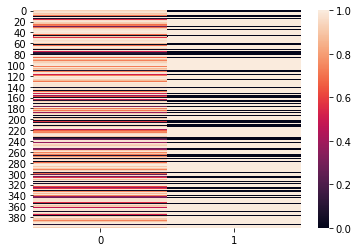

In [52]:
import seaborn as sns

with torch.no_grad():
    net.eval()
    for g in loaders['eval']:
        ...
    m = g.ndata['mask']
    y = net(g, g.ndata['x'], g.ndata['y'])[-1][m]
    y_hat = g.ndata['y_hat'][m]
    
false_pos = (y>=0.5)[~y_hat.bool()].sum() / (~y_hat.bool()).sum()
true_pos = (y>=0.5)[y_hat.bool()].sum() / (y_hat.bool()).sum()
false_neg = (y<0.5)[y_hat.bool()].sum() / (y_hat.bool()).sum()
true_neg = (y<0.5)[~y_hat.bool()].sum() / (~y_hat.bool()).sum()
error = (torch.logical_xor(y >= 0.5, y_hat.bool())).sum() / len(y)
print("Classification error: {}".format(error))
print("Sensitivity (true pos): {}".format(true_pos))
print("Specificity (true neg): {}".format(true_neg))

perc = (~torch.logical_xor(y_hat.bool(), y > 0.5)).sum() / len(y_hat)
print("Percentage correct: {}".format(perc.item()))
sns.heatmap(torch.stack([y, y_hat]).detach().numpy().T)
plt.show()

#### Looking into the black box NN models

Lets look to see what the model has learned. Remember we trained an attention network on complete graphs. Each event in our model has its own embedding and the dot product between two embeddings determines the degree to which two events *interact* within the model (i.e. **attention**). We performed a message passing algorithm, passing information through the complete graph, weighted by the **attention**. The network learned which embeddings to use and how to pass messages such that it best explains lung cancer incidence.

Note we provided *no information about the structure of the relationships*, rather the network was allowed to infer the relationship from the data itself.

One interpretation of this model is that **attenton** infers correlation between two events. We can quickly plot  attention and the underlying network with the code below. Note that we only trained the network on lung cancer (last node), and so the attention between other nodes is mostly not interpretable.

In [181]:
import seaborn as sns
import networkx as nx


def to_nxg(g: dgl.DGLGraph) -> nx.DiGraph:
    nxg = nx.DiGraph(g.to_networkx())
    return nxg
    
def plot_graph(g: dgl.DGLGraph, ax=None, prog='neato', **kwargs):
    nxg = to_nxg(g)
    pos = nx.nx_agraph.pygraphviz_layout(nxg, prog=prog)
    nx.draw(nxg, pos=pos, ax=ax, **kwargs)
    return ax, pos, nxg

def attn_to_sparse(g: dgl.DGLGraph, attn: torch.Tensor):
    n = g.number_of_nodes()
    i = torch.stack(g.edges())
    s = attn.shape
    expected_shape = (n, n, *list(s)[1:])
    x = torch.sparse_coo_tensor(i, attn, expected_shape)
    return x


def plot_multihead_attention(g, attn, cmap='binary', labels='auto', node_color='k', node_size=30, prog='neato', scale_width=2., min_width=0.3):
    fig, axes = plt.subplots(2, 4, figsize=(14, 5))
    attn_arr =[]
    
    attn_ = attn_to_sparse(g, attn.detach().squeeze(-1)).to_dense()
    for i in range(attn_.shape[-1]):
        ax = axes.flatten()[i]
        ax.set_title("Head {}".format(i))
        _attn = attn_[..., i]
        attn_arr.append(_attn)
        sns.heatmap(_attn, ax=ax, linewidths=0, cmap=cmap, xticklabels=labels, yticklabels=labels)
        norm = mpl.colors.Normalize(vmin=0,vmax=1.)
        a = _attn.flatten()
        edge_colors = cm.get_cmap(cmap)(norm(a))
        edges = g.edges()
        edgelist = [(edges[0][i].item(), edges[1][i].item()) for i in range(g.number_of_edges())]
        
        ax, pos, nxg = plot_graph(g, prog=prog, width=a*scale_width + min_width, edge_color=edge_colors, edgelist=edgelist, ax=axes.flatten()[i+4], node_size=node_size, node_color=node_color)
    plt.tight_layout()
    
def eval_network(g, net):
    net(g, g.ndata['x'], g.ndata['y'])
    attn = net.attn.layer.attn
    plot_multihead_attention(g, attn, labels=list(df.columns))
    
g = loaders['eval'].dataset[2]
net(g, g.ndata['x'], g.ndata['y'])
attn = net.attn.layer.attn.squeeze(-1)
fig, ax = plt.subplots(1, 1, figsize=(5, .5))
sns.heatmap(attn_to_sparse(g, attn).to_dense().mean(-1)[..., -1:].detach().T, ax=ax, cmap='binary', yticklabels=[''], xticklabels=df.columns)
plt.show()

eval_network(loaders['eval'].dataset[2], net)

TypeError: forward() missing 1 required positional argument: 'feature2'

From the evaluation above (probably), we can see the attention on the networks correctly identifies correlations between "coughing", "smoking", "genetics", and "lung cancer". Other features, the network has inferred, are not relevant to predicting lung cancer (e.g. car accidents, being born on an even day, etc.). This is because the model has decided that those correlations statitically be explain the data we've seen.

However, we made one crucial assumption back in our original dataset. We create a complete graph of all events, which implies that *every event must have a cause*, more specifically, every event must have a cause of the available causes originally provided in the data. Clearly, lung cancer does not cause genetics, but the other way around; lung cancer probably does not cause smoking; couging probably does not cause lung cancer. We lost the directionality of the data and are instead inferring correlations, not causation. 

What if there are outside causes to the data; out model does not consider those simply because we did not provide an avenue for backpropogation to consider such models. We could, perhaps, add additional nodes and edges representing "outside" factors.

Having no causal model means we are not able to manipulate the data generation process. This means we are unable to determine what effects would decrease incidence of lung cancer ("Should we campaign against coughing or smoking?").

### Training for Lung Cancer Prediction with Outside Causes

We attempt to add outside causes to our model, one additiona outside cause per event and see how this effects training.

#### Add outside causes transform

In [118]:
class AddIncomingEdges(typing.Callable):
    
    def __init__(self, embed_key):
        self.embed_key = embed_key
        
    def __call__(self, g):
        n = g.number_of_nodes()
        g.add_nodes(n)
        g.ndata[self.embed_key][n:] = torch.arange(n, 2*n)
        edges = torch.stack([
            torch.arange(n, 2*n),
            torch.arange(0, n),
        ])
        g.add_edges(edges[0], edges[1])
        return g
    
t = Compose(Deepcopy(), AddIncomingEdges('x'))

#### Training

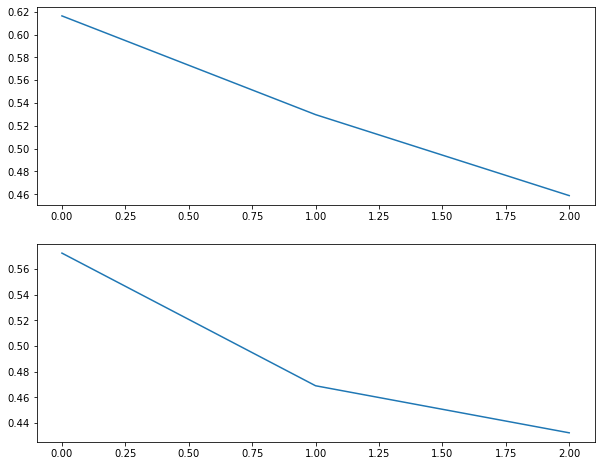

KeyboardInterrupt: 

In [320]:
from tqdm.auto import tqdm
from IPython import display


LeaveOneOutIncoming = Compose(
    Deepcopy(),
    ToDGLFullyConnected(list(df.columns), feature_key='x', target_key='y'), 
    CloneNodeData('y', 'y_hat'),
    MaskNodeData(-1, key='y', mask_key='mask', mask_value=-1),
    AddIncomingEdges('x'),
)
dataset = PdDataset(df=df, transforms=LeaveOneOutIncoming)
dataset = CachedDataset(dataset)
train_dataset, eval_dataset = dataset.split(0.8, 0.2)
datasets = {
    'train': train_dataset,
    'eval': eval_dataset,
    'full': dataset
}

loaders = {
    'train': DataLoader(datasets['train'], batch_size=32, collate_fn=dgl.batch, shuffle=True),
    'eval': DataLoader(datasets['eval'], batch_size=len(datasets['eval']), collate_fn=dgl.batch)
}

net = Network(d_model=len(df.columns)*2, h=32, n_heads=4, dropout=0.2)
optim = torch.optim.AdamW(net.parameters(), lr=1e-3)
lossfn = torch.nn.BCELoss()


def compute_loss(net, g):
    m = g.ndata['mask']
    y_arr = net(g, g.ndata['x'], g.ndata['y'])
    y_hat = g.ndata['y_hat']
    losses = []
    for y in y_arr:
        losses.append(lossfn(y[m], y_hat[m]))
    loss = torch.stack(losses)
    return loss.mean()

def compute_train_loss(net, g):
    net.train()
    return compute_loss(net, g)

def compute_eval_loss(net, g):
    net.eval()
    with torch.no_grad():
        return compute_loss(net, g)

n_epochs = 100
train_losses = []
eval_losses = []
for epoch in tqdm(range(n_epochs)):
    
    # train
    epoch_train_loss = []
    for g in loaders['train']:
        train_loss = compute_train_loss(net, g)
        optim.zero_grad()
        train_loss.backward()
        optim.step()
        epoch_train_loss.append(train_loss.detach().item())
    epoch_train_loss = torch.tensor(epoch_train_loss)
    train_losses.append((epoch, epoch_train_loss.mean()))
        
    # evaluate
    if epoch % 1 == 0:
        epoch_eval_loss = []
        for g in loaders['eval']:
            eval_loss = compute_eval_loss(net, g)
            epoch_eval_loss.append(eval_loss.detach().item())
        epoch_eval_loss = torch.tensor(epoch_eval_loss)
        eval_losses.append((epoch, epoch_eval_loss.mean()))
        
    # plot
    display.clear_output(wait=True)
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    epoch, loss = zip(*train_losses)
    axes[0].plot(epoch, loss)
    
    epoch, loss = zip(*eval_losses)
    axes[1].plot(epoch, loss)
    plt.show()
        
        

#### Evaluation

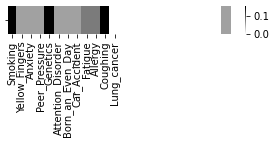

NameError: name 'a' is not defined

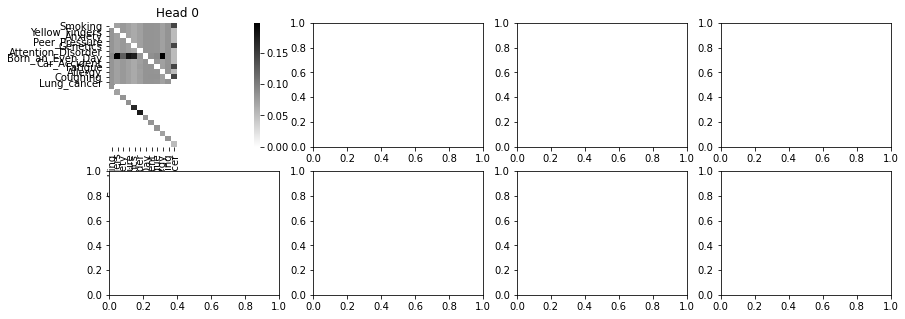

In [24]:
g = loaders['eval'].dataset[2]
net(g, g.ndata['x'], g.ndata['y'])
attn = net.attn.layer.attn.squeeze(-1)
fig, ax = plt.subplots(1, 1, figsize=(5, .5))
sns.heatmap(attn_to_sparse(g, attn).to_dense().mean(-1)[..., 11:12].detach().T, ax=ax, cmap='binary', yticklabels=[''], xticklabels=df.columns)
plt.show()

eval_network(loaders['eval'].dataset[2], net)

We can see we can a much more binary interpretation of attention for lung cancer, however, we have still lost directionality. We can see the model is still using coughing and fatigue as indicators of whether the person has lung cancer. We are still intepreting attention as 'indicators' rather than causes.

### Training for Correlations across all nodes

For our predictions above, there is nothing really special about lung cancer. We can just as well predict other events from the data. One question is whether we can generate a model that has consistent predictions for *any* event in the data. Perhaps then we can tease out causes. To do this, we simply randomize the mask we apply in the dataset.

In [119]:
        
class RandomMaskNodeData(typing.Callable):
    
    def __init__(self, key: str, mask_key='m', mask_value=0):
        self.key = key
        self.mask_key = mask_key
        self.mask_value = mask_value
        
        
    def __call__(self, g):
        mask = torch.zeros_like(g.ndata[self.key]).long()
        i = torch.randint(0, len(mask), (1,))
        mask[i] = 1
        mask = mask.bool()
        g.ndata[self.mask_key] = mask
        g.ndata[self.key][mask] = self.mask_value
        return g
        

In [332]:

    
class MultiHeadAttention(nn.Module):
    
    def __init__(self, dim_model, h):
        super().__init__()
        assert dim_model % h == 0
        self.h = h
        self.dim_model = dim_model
        self.d_k = dim_model // h
        self.linears  = clones(nn.Linear(dim_model, dim_model), 4)
        self.attn = None
    
    def _view_head(self, x):
        return x.view(x.size(0), -1, self.h, self.d_k).transpose(1, 2)
        
    def forward(self, g, query, key, value):
        q = self._view_head(self.linears[0](query))
        k = self._view_head(self.linears[1](key))
        v = self._view_head(self.linears[2](value))
        x = Fops.v_dot_u(g, q, k) / self.d_k**0.5
        score = Fops.edge_softmax(g, x)
#         score = Fops.v_dot_u(g, q, k) / self.d_k**0.5
#         score = F.leaky_relu(Fops.v_dot_u(g, q, k) / self.d_k**0.5)
        out = Fops.u_mul_e_sum(g, v, score)
        out = out.transpose(1, 2).view(g.number_of_nodes(), self.h * self.d_k)
        score = score.view(score.size(0), self.h, -1)
        self.attn = score
        out = self.linears[3](out)
        return out
    
    
class Network2(nn.Module):
    
    def __init__(self, d_model, h=16, n_heads=4, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(d_model, h)
        self.dst_linears = nn.Sequential(
            nn.Linear(h+1, h),
            nn.LeakyReLU(),
            nn.Linear(h, h),
            nn.LeakyReLU()
        )
        self.src_linears = nn.Sequential(
            nn.Linear(h+1, h),
            nn.LeakyReLU(),
            nn.Linear(h, h),
            nn.LeakyReLU()
        )
        self.encode = nn.Sequential(
            nn.Linear(1, h),
            nn.LeakyReLU(),
        )
        self.attn = AddNorm(h, layer=MultiHeadAttention(h, n_heads), dropout=dropout)
        self.self_attn = AddNorm(h, layer=MultiHeadAttention(h, n_heads), dropout=dropout)
        linear = nn.Sequential(
            nn.Linear(h, h),
            nn.LeakyReLU(),
        )
        self.core = AddNorm(h, layer=linear, dropout=dropout)
        self.decode = nn.Sequential(
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, 1)
        )
        self.l = nn.Sequential(
            nn.Linear(1, h),
            nn.LeakyReLU(),
            nn.Linear(h, h),
            nn.LeakyReLU(),
        )
            
        
    def forward(self, g, x, y, m, n_loops=5):
        with g.local_scope():
            x = self.embedding(x.flatten().long())
            x = torch.cat([x, m], 1)
            a = self.src_linears(x)
            b = self.dst_linears(x)
            g.ndata['a'] = a
            g.ndata['b'] = b
            g.ndata['h'] = self.encode(y.float())
            out_arr = []
            for i in range(n_loops):
#                 g.ndata['h'] = self.self_attn(g.ndata['h'], args=(g, g.ndata['h'], g.ndata['h'], g.ndata['h']))
                g.ndata['h'] = self.attn(g.ndata['h'], args=(g, g.ndata['a'], g.ndata['b'], g.ndata['h']))
                g.ndata['h'] = self.core(g.ndata['h'])
                out = nn.Sigmoid()(self.decode(g.ndata['h']))
                out_arr.append(out)
            
            return out_arr
        
net = Network2(d_model=len(df.columns)*2, h=128, n_heads=4, dropout=0.2)
g = dataset[0]
net(g, g.ndata['x'], g.ndata['y'], g.ndata['mask']);

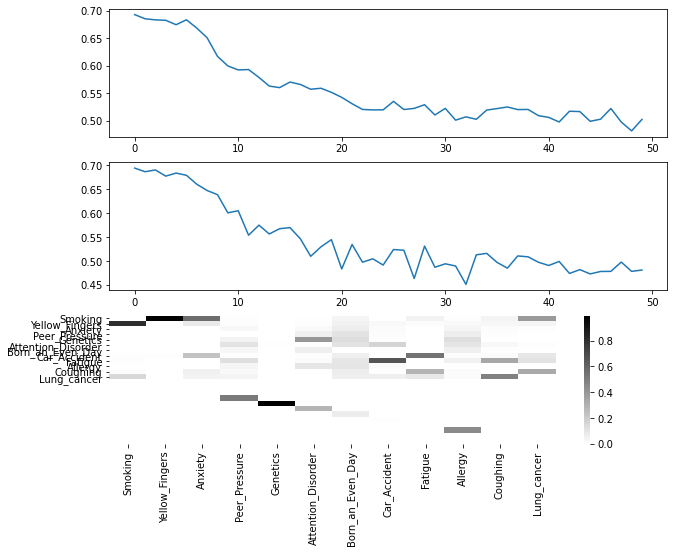

KeyboardInterrupt: 

In [346]:
from tqdm.auto import tqdm
from IPython import display


LeaveOneOutIncoming = Compose(
    Deepcopy(),
    ToDGLFullyConnected(list(df.columns), feature_key='x', target_key='y'), 
    CloneNodeData('y', 'y_hat'),
    RandomMaskNodeData(key='y', mask_key='mask', mask_value=-1),
    AddIncomingEdges('x'),
)
dataset = PdDataset(df=pd.concat([df], ignore_index=True), transforms=LeaveOneOutIncoming)
# dataset = CachedDataset(dataset)
train_dataset, eval_dataset = dataset.split(0.8, 0.2)
datasets = {
    'train': train_dataset,
    'eval': eval_dataset,
    'full': dataset
}

loaders = {
    'train': DataLoader(datasets['train'], batch_size=128, collate_fn=dgl.batch, shuffle=True),
    'eval': DataLoader(datasets['eval'], batch_size=len(datasets['eval']), collate_fn=dgl.batch)
}

net = Network2(d_model=len(df.columns)*2, h=32, n_heads=1, dropout=0.2)
optim = torch.optim.AdamW(net.parameters(), lr=1e-3)
lossfn = torch.nn.BCELoss()


def compute_loss(net, g):
    m = g.ndata['mask']
    y_arr = net(g, g.ndata['x'], g.ndata['y'], g.ndata['mask'], n_loops=3)
    y_hat = g.ndata['y_hat']
    losses = []
    for y in y_arr:
        losses.append(lossfn(y[m], y_hat[m]))
    loss = torch.stack(losses)
    return loss.mean()

def compute_train_loss(net, g):
    net.train()
    return compute_loss(net, g)

def compute_eval_loss(net, g):
    net.eval()
    with torch.no_grad():
        return compute_loss(net, g)

n_epochs = 1000
train_losses = []
eval_losses = []
device = 'cpu'
net.to(device)
for epoch in tqdm(range(n_epochs)):
    
    # evaluate
    if epoch % 1 == 0:
        epoch_eval_loss = []
        for g in loaders['eval']:
            g = g.to(device)
            eval_loss = compute_eval_loss(net, g)
            epoch_eval_loss.append(eval_loss.detach().item())
        epoch_eval_loss = torch.tensor(epoch_eval_loss)
        eval_losses.append((epoch, epoch_eval_loss.mean()))
        
    # train
    epoch_train_loss = []
    for g in loaders['train']:
        g = g.to(device)
        train_loss = compute_train_loss(net, g)
        optim.zero_grad()
        train_loss.backward()
        optim.step()
        epoch_train_loss.append(train_loss.detach().item())
    epoch_train_loss = torch.tensor(epoch_train_loss)
    train_losses.append((epoch, epoch_train_loss.mean()))
        
    # plot
    display.clear_output(wait=True)
    fig, axes = plt.subplots(3, 1, figsize=(10, 8))
    epoch, loss = zip(*train_losses)
    axes[0].plot(epoch, loss)
    
    epoch, loss = zip(*eval_losses)
    axes[1].plot(epoch, loss)
    
    g = loaders['eval'].dataset[2]
    net(g, g.ndata['x'], g.ndata['y'], g.ndata['mask'])
    attn = net.attn.layer.attn.squeeze(-1).detach()
    attn = attn_to_sparse(g, attn).to_dense()
    x = attn.mean(-1)[:, :12]

    sns.heatmap(x, cmap='binary', xticklabels=list(df.columns), yticklabels=list(df.columns), ax=axes[2])
    plt.show()
    
        
        

<AxesSubplot:>

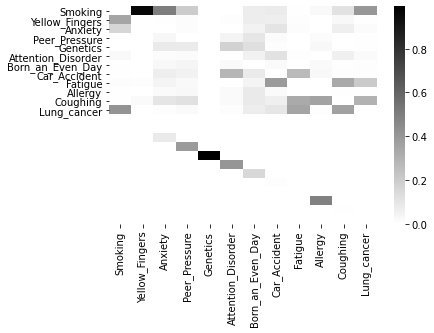

In [341]:
g = loaders['eval'].dataset[2]
net(g, g.ndata['x'], g.ndata['y'], g.ndata['mask'])
attn = net.attn.layer.attn.squeeze(-1).detach()
attn = attn_to_sparse(g, attn).to_dense()
x = attn.mean(-1)[:, :12]

sns.heatmap(x, cmap='binary', xticklabels=list(df.columns), yticklabels=list(df.columns))

<AxesSubplot:>

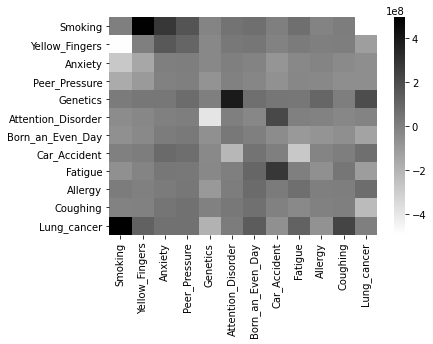

In [473]:

sns.heatmap((x.T - x) / (x.T - x).mean(), cmap='binary', xticklabels=list(df.columns), yticklabels=list(df.columns))

#### Conclusion

Consider that a bayesian networks is just a type of computation graph, one governed by joint probability tables. There is little reason we cannot model other data generation processes. For example transcriptional networks can be modeled as a type of computation graph, like an ODE network.

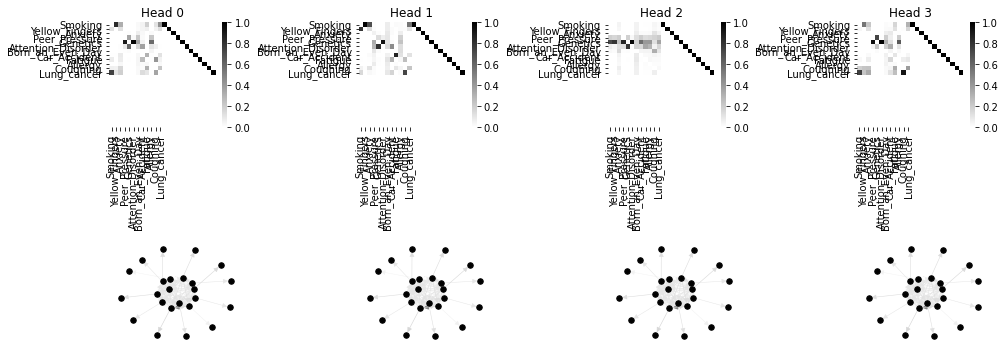

In [380]:
eval_network(loaders['eval'].dataset[2], net)

### Training using Local Events Model (FAILED)

In these examples instead of providing the neural network with a complete graph, we provide only those nodes and edges for events that occur in the data, hopefully forcing the model similar to the original data generation model. 

To illustrate, if we are provided with two examples:

| A | B | C |
| - | - | - |
| 1 | 0 | 1 |
| 1 | 1 | 0 |

We would supply graphs of the nature `A --> C` and `A --> C <-- B` rather than the full graph. In this model, the absence of an event cannot *cause* anything, but may allow other events to happen by their own causes. We will call this the **"Local Events Model"**. Again, as in the previous example, we also add independent cuases to our model.

We may be able to tease out causality, if provided with enough different events.

**NOTE: This does not work. This is because the network never learns the *non-interacting* embeddings in the graph, it therefore does not understand the interactions when you give it the full graph.**

In [288]:
import random
class AddIncomingEdges2(typing.Callable):
    
    def __init__(self, embed_key, length):
        self.embed_key = embed_key
        self.length = length
        
    def __call__(self, g):
        n = g.number_of_nodes()
        g.add_nodes(n)
        g.ndata[self.embed_key][n:] = g.ndata[self.embed_key][:n] + self.length
        edges = torch.stack([
            torch.arange(n, 2*n),
            torch.arange(0, n),
        ])
        g.ndata['y'][:] = 1
        g.ndata['y_hat'][n:] = 1
        g.add_edges(edges[0], edges[1])
        return g
    
    
class AddCompleteEdges(typing.Callable):
    
    @staticmethod
    def leading_zero(x):
        yield torch.zeros_like(x[0])
        yield from x
        
    @classmethod
    def get_complete_edges(cls, g):
        x = torch.cumsum(g.batch_num_nodes(), 0)
        all_edges = []
        for a, b in zip(cls.leading_zero(x), x):
            edges = torch.combinations(torch.arange(a, b))
            all_edges.append(edges)
        return torch.cat(all_edges, 0).T

    @classmethod
    def add_complete_edges(cls, g):
        n1 = g.number_of_nodes()
        edges = cls.get_complete_edges(g)
        g.add_edges(edges[0], edges[1])
        g.add_edges(edges[1], edges[0])
        n2 = g.number_of_nodes()
        assert n1 == n2
        return g
    
    def __call__(self, g):
        self.add_complete_edges(g)
        return g

class ToLocalEventsGraph(typing.Callable):
    
    def __init__(self, events):
        self.events = list(events)
        self.events_to_index = {e: i for i, e in enumerate(events)}
        
    def from_events(self, local_events, target_event, target_value):
        
        local_events = local_events[:]
        target_event = random.choice(self.events)
        if target_event not in local_events:
            local_events.append(target_event)
        target_idx = local_events.index(target_event)

        g = dgl.graph(([], []))
        g.add_nodes(len(local_events))

        g.ndata['x'] = torch.tensor([event_to_index[e] for e in local_events])
        m = torch.zeros_like(g.ndata['x'])
        m[target_idx] = 1
        m = m.bool()
        g.ndata['mask'] = m
        g.ndata['y'] = torch.ones_like(g.ndata['x'].unsqueeze(-1)).float()
        g.ndata['y_hat'] = g.ndata['y'].detach().clone()
        g.ndata['y_hat'][m] = target_value
        return g
        
    def __call__(self, row):
        local_events = []
        for k, v in dict(row).items():
            if v == 1:
                local_events.append(k)

        target_event = random.choice(events)
        target_value = dict(row)[target_event]
        return self.from_events(local_events, target_event, target_value)


transform = Compose(
    ToLocalEventsGraph(events=df.columns),
    AddCompleteEdges(),
    AddIncomingEdges2('x', len(df.columns))
)
g = transform(row)
print(g)
print(g.ndata)

Graph(num_nodes=16, num_edges=64,
      ndata_schemes={'x': Scheme(shape=(), dtype=torch.int64), 'mask': Scheme(shape=(), dtype=torch.bool), 'y': Scheme(shape=(1,), dtype=torch.float32), 'y_hat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})
{'x': tensor([ 0,  1,  3,  8,  9, 10, 11,  6, 12, 13, 15, 20, 21, 22, 23, 18]), 'mask': tensor([False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False]), 'y': tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]), 'y_hat': tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])}


In [289]:
class Network3(nn.Module):
    
    def __init__(self, d_model, h=32, n_heads=4, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(d_model, h)
        self.dst_linears = nn.Sequential(
            nn.Linear(h+1, h),
            nn.LeakyReLU(),
            nn.Linear(h, h),
            nn.LeakyReLU()
        )
        self.src_linears = nn.Sequential(
            nn.Linear(h+1, h),
            nn.LeakyReLU(),
            nn.Linear(h, h),
            nn.LeakyReLU()
        )
        self.encode = nn.Sequential(
            nn.Linear(h, h),
            nn.LeakyReLU(),
        )
        self.attn = AddNorm(h, layer=MultiHeadAttention(h, n_heads), dropout=dropout)
        self.self_attn = AddNorm(h, layer=MultiHeadAttention(h, n_heads), dropout=dropout)
        linear = nn.Sequential(
            nn.Linear(h, h),
            nn.LeakyReLU(),
        )
        self.core = AddNorm(h, layer=linear, dropout=dropout)
        self.decode = nn.Sequential(
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, 1)
        )
            
        
    def forward(self, g, x, y, m, n_loops=5):
        with g.local_scope():
            x = self.embedding(x.flatten().long())
            x = torch.cat([x, m.float().unsqueeze(1)], 1)
            a = self.src_linears(x)
            b = self.dst_linears(x)
            g.ndata['a'] = a
            g.ndata['b'] = b
            g.ndata['h'] = self.encode(torch.ones(a.shape))
            out_arr = []
            for i in range(n_loops):
                g.ndata['h'] = self.attn(g.ndata['h'], args=(g, g.ndata['a'], g.ndata['b'], g.ndata['h']))
                g.ndata['h'] = self.core(g.ndata['h'])
                out = nn.Sigmoid()(self.decode(g.ndata['h']))
                out_arr.append(out)
            return out_arr
        
transform = Compose(
    ToLocalEventsGraph(events=df.columns),
    AddCompleteEdges(),
    AddIncomingEdges2('x', len(df.columns))
)
g = transform(row)
net3 = Network3(len(df.columns)*2)
net3(g, g.ndata['x'], g.ndata['y'], g.ndata['mask'])[-1]

tensor([[0.4411],
        [0.4206],
        [0.4274],
        [0.4531],
        [0.4163],
        [0.3769],
        [0.4320],
        [0.4564],
        [0.4332],
        [0.4227],
        [0.4301],
        [0.4112],
        [0.4197],
        [0.4384]], grad_fn=<SigmoidBackward>)

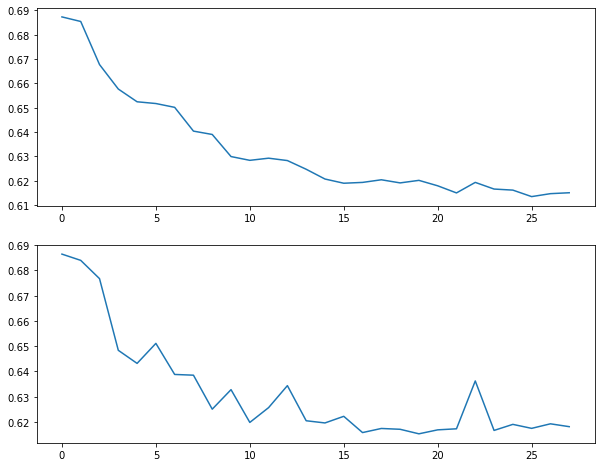

KeyboardInterrupt: 

In [290]:
from tqdm.auto import tqdm
from IPython import display


LocalEvents = Compose(
    ToLocalEventsGraph(events=df.columns),
    AddCompleteEdges(),
    AddIncomingEdges2('x', length=len(df.columns))
)
dataset = PdDataset(df=pd.concat([df, df, df, df, df, df], ignore_index=True), transforms=LocalEvents)
dataset = CachedDataset(dataset)
train_dataset, eval_dataset = dataset.split(0.8, 0.2)
datasets = {
    'train': train_dataset,
    'eval': eval_dataset,
    'full': dataset
}

loaders = {
    'train': DataLoader(datasets['train'], batch_size=128, collate_fn=dgl.batch, shuffle=True),
    'eval': DataLoader(datasets['eval'], batch_size=len(datasets['eval']), collate_fn=dgl.batch)
}

net = Network3(d_model=len(df.columns)*2, h=32, n_heads=4, dropout=0.2)
for g in loaders['train']:
    net(g, g.ndata['x'], g.ndata['y'], g.ndata['mask'])
    break
optim = torch.optim.AdamW(net.parameters(), lr=1e-3)
lossfn = torch.nn.BCELoss()


def compute_loss(net, g):
    m = g.ndata['mask']
    y_arr = net(g, g.ndata['x'], g.ndata['y'], g.ndata['mask'], n_loops=3)
    y_hat = g.ndata['y_hat']
    losses = []
    for y in y_arr[-1:]:
        losses.append(lossfn(y[m], y_hat[m]))
    loss = torch.stack(losses)
    return loss.mean()

def compute_train_loss(net, g):
    net.train()
    return compute_loss(net, g)

def compute_eval_loss(net, g):
    net.eval()
    with torch.no_grad():
        return compute_loss(net, g)

n_epochs = 100
train_losses = []
eval_losses = []
for epoch in tqdm(range(n_epochs)):
    
    # evaluate
    if epoch % 1 == 0:
        epoch_eval_loss = []
        for g in loaders['eval']:
            eval_loss = compute_eval_loss(net, g)
            epoch_eval_loss.append(eval_loss.detach().item())
        epoch_eval_loss = torch.tensor(epoch_eval_loss)
        eval_losses.append((epoch, epoch_eval_loss.mean()))
        
    # train
    epoch_train_loss = []
    for g in loaders['train']:
        train_loss = compute_train_loss(net, g)
        optim.zero_grad()
        train_loss.backward()
        optim.step()
        epoch_train_loss.append(train_loss.detach().item())
    epoch_train_loss = torch.tensor(epoch_train_loss)
    train_losses.append((epoch, epoch_train_loss.mean()))
        
    # plot
    display.clear_output(wait=True)
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    epoch, loss = zip(*train_losses)
    axes[0].plot(epoch, loss)
    
    epoch, loss = zip(*eval_losses)
    axes[1].plot(epoch, loss)
    plt.show()
        
        

In [263]:
g.ndata['mask']

tensor([False, False, False,  ..., False, False, False])

<AxesSubplot:>

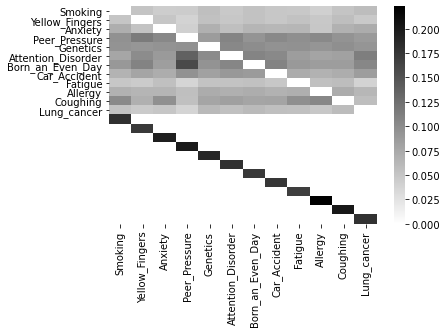

In [294]:
g = ToLocalEventsGraph(df.columns).from_events(list(df.columns), 'Lung_cancer', 1)
g = AddCompleteEdges()(g)
g = AddIncomingEdges2('x', len(df.columns))(g)

net(g, g.ndata['x'], g.ndata['y'], g.ndata['mask'])
attn = net.attn.layer.attn.squeeze(-1).detach()
attn = attn_to_sparse(g, attn).to_dense()
x = attn.mean(-1)[:, :12]

sns.heatmap(x, cmap='binary', xticklabels=list(df.columns), yticklabels=list(df.columns))

In [297]:
g = ToLocalEventsGraph(df.columns).from_events(list(df.columns), 'Smoking', 1)
g = AddCompleteEdges()(g)
g = AddIncomingEdges2('x', len(df.columns))(g)

x = net(g, g.ndata['x'], torch.ones_like(g.ndata['y']), g.ndata['mask'])

print(x[-1][g.ndata['mask']])
g.ndata['y_hat'][g.ndata['mask']]

tensor([[0.8409]], grad_fn=<IndexBackward>)


tensor([[1.]])

tensor([[0.8729]], grad_fn=<IndexBackward>)
tensor([[0.]])


<AxesSubplot:>

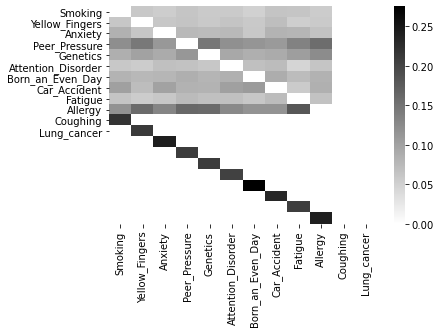

In [311]:
g = loaders['eval'].dataset[2]
out = net(g, g.ndata['x'], g.ndata['y'], g.ndata['mask'])[-1]
attn = net.attn.layer.attn.squeeze(-1).detach()
attn = attn_to_sparse(g, attn).to_dense()
x = attn.mean(-1)[:, :12]

print(out[g.ndata['mask']])
print(g.ndata['y_hat'][g.ndata['mask']])

sns.heatmap(x, cmap='binary', xticklabels=list(df.columns), yticklabels=list(df.columns))

## Conclusion

To finally make a conclusion from all of this, generating the causal data generation model from data that has no temporal component is not possible. What we've done here is generate a deep diagnostic network, attention being the most relevant components in making a diagnosis. This has no implications on the causal model.

# Generative Attention Network (FAILED)

We shift our focus to generative networks. Our network will now product logits from which we will perform a soft max sampling.

**note this seems not to work at all**

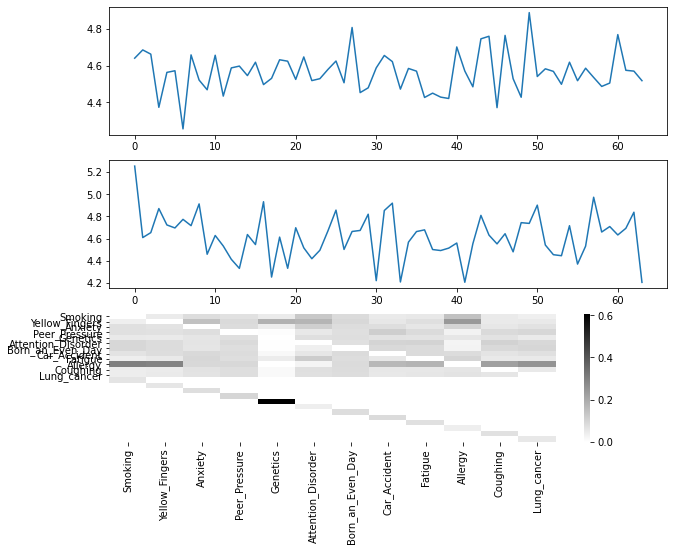

In [ ]:
from torch.nn import functional as F
from tqdm.auto import tqdm
from IPython import display

class GumbelSoftMaxSampler(nn.Module):
    
    def __init__(self, hard=False):
        super().__init__()
        self.hard = hard
        
    def forward(self, logits):
        return F.gumbel_softmax(logits=logits, hard=self.hard)

    
class Parallel(nn.Module):
    
    def __init__(self, *modules):
        super().__init__()
        self.mods = nn.ModuleList(modules)
        self.n_modules = len(modules)
        
    def forward(self, x):
        assert x.shape[-1] == len(self.mods)
        out = []
        for i, mod in enumerate(self.mods):
            _x = x[..., i]
            try:
                result = mod(_x)
            except Exception as e:
                msg = "Error found in forward prop of module {}, {}\n".format(i, str(mod)[:1000])
                msg = msg + str(e)
                raise e.__class__(msg)
            out.append(result)
        return torch.cat(out, 1)
    
    
class ParallelEmbedding(Parallel):
    
    def __init__(self, *dims):
        mods = []
        for a, b in dims:
            mods.append(nn.Embedding(a, b))
        super().__init__(*mods)
        
    
class Dense(nn.Module):
    
    def __init__(self, *dims, dropout=0.2):
        super().__init__()
        layers = []
        for a, b in zip(dims[:-1], dims[1:]):
            layers += [nn.Linear(a, b), nn.LeakyReLU(), nn.Dropout(dropout)]
        self.layers = nn.Sequential(*layers)
        
    def __call__(self, x):
        return self.layers(x)
    
    
x = torch.randn(10, 12)
encoder = Dense(12, 16, 16, 2)
sampler = GumbelSoftMaxSampler()
decoder = Dense(2, 16, 16, 12)

x = torch.randn(10, 12)
logits = encoder(x)
y = sampler(logits)
x = decoder(y)
print(x.shape)

class GenerativeNetwork(nn.Module):
    
    def __init__(self, d_model, h=32, n_heads=4, dropout=0.2):
        super().__init__()
        
        # embedding for src nodes
        self.src_embed = nn.Sequential(
            nn.Embedding(d_model, h),
            Dense(h, h, dropout=dropout)
        )
        
        # embedding for dst nodes
        self.dst_embed = nn.Sequential(
            nn.Embedding(d_model, h),
            Dense(h, h, dropout=dropout)
        )

        # embedding to parameterize the "combining" function for inputs
        self.embed = nn.Sequential(
            ParallelEmbedding((d_model, h), (2, 1)),
            Dense(h+1, h, dropout=dropout)
        )

        # encode incoming data
        self.encoder = nn.Sequential(
            Dense(h + 2, h, dropout=dropout)
        )
        
        # attention to determine interactions
        self.attn = AddNorm(h, layer=MultiHeadAttention(h, n_heads), dropout=dropout)

        # decode to logits
        self.decoder = nn.Sequential(
            Dense(h, h),
            nn.Linear(h, 2)
        )
        
        # sample from logits
        self.sampler = GumbelSoftMaxSampler(hard=True)

    def forward(self, g, feature, target, feature2, n_loops=3):
        with g.local_scope():
            q = self.src_embed(feature)
            k = self.dst_embed(feature)
            
            m = torch.stack([feature, feature2], -1)
            m = self.embed(m)
            x = target
            out = [x]
            for i in range(n_loops):
                h = torch.cat([x, m], 1)
                v = self.encoder(h)
                h = self.attn(v, args=(g, q, k, v))
                logits = self.decoder(h)
#                 x = self.sampler(logits)
                x = nn.Sigmoid()(logits)
                out.append(x)
            return out

gennet = GenerativeNetwork(len(df.columns)*2)

g = dgl.graph(([0, 1, 2], [0, 2, 3]))
feature = torch.randint(0, 3, (g.number_of_nodes(),))
feature2 = torch.randint(0, 1, (g.number_of_nodes(),))
target = torch.randn(g.number_of_nodes(), 2)
gennet(g, feature, target, feature2)


def one_hot(x: torch.Tensor, num_classes: int, device=None, dtype=torch.long):
    to_shape = None
    if len(x.shape) > 1:
        to_shape = tuple(x.shape) + (num_classes,)
        x = x.flatten()
    b = torch.zeros(x.shape[0], num_classes, device=device, dtype=dtype)
    b[torch.arange(x.shape[0], device=device), x.to(device)] = 1
    if to_shape:
        b = b.view(to_shape)
    return b

class OneHotNode(typing.Callable):
    
    def __init__(self, key, num_classes, out_key=None, dtype=torch.long):
        self.num_classes = num_classes
        self.key = key
        if out_key is None:
            self.out_key = self.key
        self.dtype = dtype
        
    def __call__(self, g):
        g.ndata[self.out_key] = one_hot(g.ndata[self.key].long(), self.num_classes, dtype=self.dtype)
        return g
        

class NodeSqueeze(typing.Callable):
    
    def __init__(self, key, dim):
        self.dim = dim
        self.key = key
        
    def __call__(self, g):
        g.ndata[self.key] = g.ndata[self.key].squeeze(self.dim)
        return g

Transforms = Compose(
    Deepcopy(),
    ToDGLFullyConnected(list(df.columns), feature_key='x', target_key='y'), 
    CloneNodeData('y', 'y_hat'),
    RandomMaskNodeData(key='y', mask_key='mask', mask_value=1),
    AddIncomingEdges('x'),
    OneHotNode('y', 2, dtype=torch.float),
    OneHotNode('y_hat', 2, dtype=torch.float),
    NodeSqueeze('y', 1),
    NodeSqueeze('y_hat', 1)
)
dataset = PdDataset(df=pd.concat([df], ignore_index=True), transforms=Transforms)
# dataset = CachedDataset(dataset)
train_dataset, eval_dataset = dataset.split(0.8, 0.2)
datasets = {
    'train': train_dataset,
    'eval': eval_dataset,
    'full': dataset
}

loaders = {
    'train': DataLoader(datasets['train'], batch_size=128, collate_fn=dgl.batch, shuffle=True),
    'eval': DataLoader(datasets['eval'], batch_size=len(datasets['eval']), collate_fn=dgl.batch)
}


net = gennet = GenerativeNetwork(len(df.columns)*2)
optim = torch.optim.AdamW(net.parameters(), lr=1e-3)
lossfn = torch.nn.BCELoss()

for g in loaders['eval']:
    net(g, g.ndata['x'].flatten(), g.ndata['y'], g.ndata['mask'].long().flatten())
    
    
def compute_loss(net, g):
    m = g.ndata['mask'].flatten()
    y_arr = net(g, g.ndata['x'].view(-1), g.ndata['y'], g.ndata['mask'].long().view(-1), n_loops=10)
    y_hat = g.ndata['y_hat']
    losses = []
    for y in y_arr:
        losses.append(lossfn(y[m], y_hat[m]))
    loss = torch.stack(losses)
    return loss.mean()


def compute_train_loss(net, g):
    net.train()
    return compute_loss(net, g)


def compute_eval_loss(net, g):
    net.eval()
    with torch.no_grad():
        return compute_loss(net, g)

n_epochs = 1000
train_losses = []
eval_losses = []
device = 'cpu'
net.to(device)
for epoch in tqdm(range(n_epochs)):
    
    # evaluate
    if epoch % 1 == 0:
        epoch_eval_loss = []
        for g in loaders['eval']:
            g = g.to(device)
            eval_loss = compute_eval_loss(net, g)
            epoch_eval_loss.append(eval_loss.detach().item())
        epoch_eval_loss = torch.tensor(epoch_eval_loss)
        eval_losses.append((epoch, epoch_eval_loss.mean()))
        
    # train
    epoch_train_loss = []
    for g in loaders['train']:
        g = g.to(device)
        train_loss = compute_train_loss(net, g)
        optim.zero_grad()
        train_loss.backward()
        optim.step()
        epoch_train_loss.append(train_loss.detach().item())
    epoch_train_loss = torch.tensor(epoch_train_loss)
    train_losses.append((epoch, epoch_train_loss.mean()))
        
    # plot
    display.clear_output(wait=True)
    fig, axes = plt.subplots(3, 1, figsize=(10, 8))
    epoch, loss = zip(*train_losses)
    axes[0].plot(epoch, loss)
    
    epoch, loss = zip(*eval_losses)
    axes[1].plot(epoch, loss)
    
    g = loaders['eval'].dataset[2]
    out = net(g, g.ndata['x'].flatten(), g.ndata['y'], g.ndata['mask'].flatten().long())
    attn = net.attn.layer.attn.squeeze(-1).detach()
    attn = attn_to_sparse(g, attn).to_dense()
    x = attn.mean(-1)[:, :12]

    sns.heatmap(x, cmap='binary', xticklabels=list(df.columns), yticklabels=list(df.columns), ax=axes[2])
    plt.show()

In [200]:
g.ndata['y_hat']

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [150]:
import seaborn as sns

def to_nxg(g: dgl.DGLGraph) -> nx.DiGraph:
    nxg = nx.DiGraph(g.to_networkx())
    return nxg
    
def plot_graph(g: dgl.DGLGraph, ax=None, prog='neato', **kwargs):
    nxg = to_nxg(g)
    pos = nx.nx_agraph.pygraphviz_layout(nxg, prog=prog)
    nx.draw(nxg, pos=pos, ax=ax, **kwargs)
    return ax, pos, nxg

def attn_to_sparse(g: dgl.DGLGraph, attn: torch.Tensor):
    n = g.number_of_nodes()
    i = torch.stack(g.edges())
    v = attn
    x = torch.sparse_coo_tensor(i, v.flatten(), (n, n))
    return x


def plot_multihead_attention(g, attn, cmap='binary', node_color='k', node_size=30, prog='neato', scale_width=2., min_width=0.3):
    fig, axes = plt.subplots(3, 4, figsize=(14, 5))
    attn_arr =[]
    for i in range(attn.size(1)):
        ax = axes.flatten()[i]
        ax.set_title("Head {}".format(i))
        a = attn[:, i].detach().flatten()
        _attn = attn_to_sparse(g, a).to_dense().numpy()
        attn_arr.append(_attn)
        sns.heatmap(_attn, ax=ax, linewidths=0, cmap=cmap)
        norm = mpl.colors.Normalize(vmin=0,vmax=1.)
        edge_colors = cm.get_cmap(cmap)(norm(a))
        edges = g.edges()
        edgelist = [(edges[0][i].item(), edges[1][i].item()) for i in range(g.number_of_edges())]
        
        ax, pos, nxg = plot_graph(g, prog=prog, width=a*scale_width + min_width, edge_color=edge_colors, edgelist=edgelist, ax=axes.flatten()[i+4], node_size=node_size, node_color=node_color)
#         nx.draw_networkx_labels(g, ax=ax, pos=pos, labels={v: v for v in list(range(g.number_of_nodes()))})
    plt.show()
    avg = np.stack(attn_arr).mean(0)
    print(avg.shape)
    sns.heatmap(avg, linewidths=0, cmap=cmap)
    return avg, attn_arr
g = eval_loader.dataset[0]
net(g)
net.attn.layer.attn.shape

print(df.columns)
a, arr = plot_multihead_attention(g, net.attn.layer.attn)


NameError: name 'eval_loader' is not defined

In [772]:
a = np.stack(arr).mean(0)
x = a.flatten()

idx = np.argwhere(x > 0.1).flatten()

edges = np.unravel_index(idx, (24, 24))

nxg = nx.DiGraph()

for n1, n2 in zip(*edges):
    node1 = df.columns[n1]
    node2 = df.columns[n2]
    val = a[n1, n2]
    nxg.add_node(n1, name=node1)
    nxg.add_node(n2, name=node2)
    nxg.add_edge(n1, n2, val=val)
    

pos = nx.nx_agraph.pygraphviz_layout(nxg, prog='dot')
labels = {n: ndata['name'] for n, ndata in nxg.nodes(data=True)}
nx.draw(nxg, pos=pos, labels=labels, node_size=300, node_color='w', width=1)

IndexError: index 12 is out of bounds for axis 0 with size 12

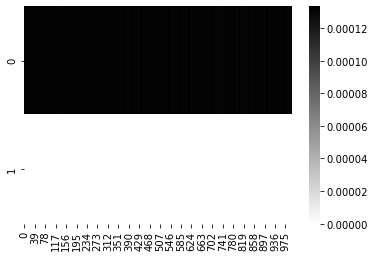

In [779]:

total_loss = 0
for g in eval_loader:
    net.eval()
    with torch.no_grad():
        m = g.ndata['mask'].bool()
        y = net(g)[-1][m]
        y_hat = g.ndata['y_hat'][m].float()
        
        x = torch.stack([y, y_hat]).squeeze(-1)
        sns.heatmap(x.detach().numpy(), cmap='binary')

#### TODO: maybe don't just use a mask, but use a different graph structure to predict?

What if, if a cause is present we add it to the graph and we choose a comletely random node and try to predict whether it should be on or off.

In [645]:
import random



class LungCancerDataset_OneTarget(Dataset):
    
    def __init__(self, df):
        self.df = df
        self.acquired = {}
        
    def __getitem__(self, i):
        row = df.iloc[i]
        local_causes = []
        for k, v in row.items():
            if v == 1:
                local_causes.append(k)

        target_outcomes = [random.choice(df.columns)]
        local_causes = sorted(list(set(local_causes).union(set(target_outcomes))))

        target_mask = torch.zeros(len(local_causes))
        for i, x in enumerate(local_causes):
            if x == target_outcome:
                target_mask[i] = 1

        g = dgl.graph(([], []))
        g.add_nodes(len(local_causes))
        g.ndata['x'] = torch.tensor([cause_to_idx[c] for c in local_causes]).unsqueeze(1)
        y = torch.tensor(row[target_outcomes].values).unsqueeze(0)
        y = y.expand(g.number_of_nodes(), -1)
        g.ndata['y'] = y
        g.ndata['target_mask'] = target_mask
        add_complete_edges(g)
        assert g.number_of_nodes()
        return g
    
    def __len__(self):
        return len(self.df)


In [666]:
class Network2(nn.Module):
    
    def __init__(self, d_model, h=16, n_heads=4, dropout=0.2):
        super().__init__()
        self.src_embedding = nn.Sequential(
            nn.Embedding(d_model, h),
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, h),
            nn.LeakyReLU()
        )
        self.dst_embedding = nn.Sequential(
            nn.Embedding(d_model, h),
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, h),
            nn.LeakyReLU()
        )
        self.embedding = nn.Sequential(
            nn.Embedding(d_model, h),
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, h),
            nn.LeakyReLU()
        )
        self.attn = AddNorm(h, layer=MultiHeadAttention(h, n_heads), dropout=dropout)
        self.core = nn.Sequential(
            nn.Linear(h, h),
            nn.LeakyReLU(),
        )
        self.decode = nn.Sequential(
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, 1)
        )
            
        
    def forward(self, g, n_loops=5):
        with g.local_scope():
            g.ndata['a'] = self.src_embedding(g.ndata['x'].flatten().long())
            g.ndata['b'] = self.dst_embedding(g.ndata['x'].flatten().long())
            g.ndata['h'] = self.embedding(g.ndata['x'].flatten().long())
            out_arr = []

            for i in range(n_loops):
                g.ndata['h'] = self.attn(g.ndata['h'], args=(g, g.ndata['a'], g.ndata['b'], g.ndata['h']))
                g.ndata['h'] = self.core(g.ndata['h'])
                out = nn.Sigmoid()(self.decode(g.ndata['h']))
                out_arr.append(out[g.ndata['target_mask'].bool()])
            return torch.stack(out_arr)
        
net = Network2(32)


dataset = LungCancerDataset_OneTarget(df.iloc[:-100])
loader = DataLoader(dataset, batch_size=32, collate_fn=dgl.batch, shuffle=True)
for x in loader:
    ...
# set out to predict each node in the graph as apposed to just predicting lung cancer
# we are not making any assumptions that lung_cancer is the target which we seek to understand
# rather, we try to learn the entire causal graph
net(x).shape

torch.Size([5, 8, 1])

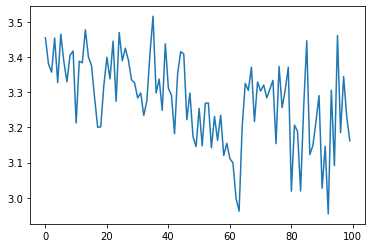

Exception ignored in: <function _releaseLock at 0x7f37ff325550>
Traceback (most recent call last):
  File "/home/justin/anaconda3/envs/openaigym/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 42684, 42696, 42708, 42709, 42721, 42733, 42745) exited unexpectedly

In [669]:
from tqdm.auto import tqdm
from IPython import display
from matplotlib import pylab as plt

net = Network2(d_model=len(df.columns), h=128, n_heads=8, dropout=0.2)

dataset = LungCancerDataset_OneTarget(df.iloc[:-1000])
loader = DataLoader(dataset, batch_size=256, collate_fn=dgl.batch, shuffle=True, num_workers=12)

eval_dataset = LungCancerDataset_OneTarget(df.iloc[-1000:])
eval_loader = DataLoader(dataset, batch_size=len(eval_dataset), collate_fn=dgl.batch, shuffle=False)

optim = torch.optim.AdamW(net.parameters(), lr=1e-3)
lossfn = torch.nn.BCELoss()
losses = []

def evaluate():
    total_loss = 0
    for g in eval_loader:
        net.eval()
        with torch.no_grad():
            y_arr = net(g)[-1:]
            y_hat = g.ndata['y'][g.ndata['target_mask'].bool()]
            loss = torch.tensor(0.)
            for y in y_arr:
                loss += lossfn(y, y_hat.float())
            
            total_loss+=loss.detach().item()
    return total_loss

eval_losses = []
for epoch in tqdm(range(1000)):
    for g in loader:
        y_arr = net(g)
        y_hat = g.ndata['y'][g.ndata['target_mask'].bool()]
        loss = torch.tensor(0.)
        for y in y_arr:
            loss += lossfn(y, y_hat.float())
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.detach().item())
        display.clear_output(wait=True)
        plt.plot(losses)
        plt.show()
        
#         display.clear_output(wait=True)
#         plt.plot(eval_losses)
#         plt.show()
        
    if epoch % 1 == 0:
        eval_loss = evaluate()
        eval_losses.append(eval_loss)
